<a href="https://colab.research.google.com/github/singhnidh/Plant-disease-detection-using-Deep-Learning-and-Machine-Vision/blob/main/GAN_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
import numpy as np
from PIL import Image
from tqdm import tqdm
import os
import time
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
GENERATE_RES = 3 # Generation resolution factor
# (1=32, 2=64, 3=96, 4=128, etc.)
GENERATE_SQUARE = 32 * GENERATE_RES # rows/cols (should be square)
IMAGE_CHANNELS = 3

In [ ]:
# Preview image
PREVIEW_ROWS = 1
PREVIEW_COLS = 1
PREVIEW_MARGIN = 16

In [ ]:
# Size vector to generate images from
SEED_SIZE = 100


In [ ]:
# Configuration
DATA_PATH = '/content/drive/MyDrive/VIT PROJECT WORK/Mater Project VIT FINAL SEM/ DATASET/PlantVillage-Dataset/Apple___healthy'
EPOCHS = 500
BATCH_SIZE = 32
BUFFER_SIZE = 60000

In [ ]:
print(f"Will generate {GENERATE_SQUARE}px square images.")
#output('Will generate 96px square images.')

Will generate 96px square images.


In [ ]:
training_binary_path = os.path.join(DATA_PATH,
        f'training_data_{GENERATE_SQUARE}_{GENERATE_SQUARE}.npy')

In [ ]:
print(f"Looking for file: {training_binary_path}")

Looking for file: /content/drive/MyDrive/VIT PROJECT WORK/Mater Project VIT FINAL SEM/ DATASET/PlantVillage-Dataset/Apple___healthy/training_data_96_96.npy


In [ ]:
def hms_string(seconds):
    hours, remainder = divmod(seconds, 3600)
    minutes, seconds = divmod(remainder, 60)
    return f"{int(hours)}:{int(minutes)}:{int(seconds)}"

# Rest of your code...

if not os.path.isfile(training_binary_path):
    start = time.time()
    print("Loading training images...")

    training_data = []
    faces_path = os.path.join(DATA_PATH)
    for filename in tqdm(os.listdir(faces_path)):
        path = os.path.join(faces_path, filename)
        if os.path.isfile(path):  # Check if it's a regular file
            try:
                image = Image.open(path).resize((GENERATE_SQUARE, GENERATE_SQUARE), Image.ANTIALIAS)
                training_data.append(np.asarray(image))
            except:
                print(f"Error processing image: {path}")

    training_data = np.reshape(training_data, (-1, GENERATE_SQUARE, GENERATE_SQUARE, IMAGE_CHANNELS))
    training_data = training_data.astype(np.float32)
    training_data = training_data / 127.5 - 1.

    print("Saving training image binary...")
    np.save(training_binary_path, training_data)
    elapsed = time.time() - start
    print(f'Image preprocess time: {hms_string(elapsed)}')
else:
    print("Loading previous training pickle...")
    training_data = np.load(training_binary_path)


Loading previous training pickle...


In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(training_data).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

#**we actually build the discriminator and the generator. Both will be trained with the Adam optimizer.**

In [ ]:
def build_generator(seed_size, channels):
    model = Sequential()

    model.add(Dense(4*4*256,activation="relu",input_dim=seed_size))
    model.add(Reshape((4,4,256)))

    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    # Output resolution, additional upsampling
    model.add(UpSampling2D())
    model.add(Conv2D(128,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    if GENERATE_RES>1:
      model.add(UpSampling2D(size=(GENERATE_RES,GENERATE_RES)))
      model.add(Conv2D(128,kernel_size=3,padding="same"))
      model.add(BatchNormalization(momentum=0.8))
      model.add(Activation("relu"))

    # Final CNN layer
    model.add(Conv2D(channels,kernel_size=3,padding="same"))
    model.add(Activation("tanh"))

    return model



In [ ]:
def build_discriminator(image_shape):
    model = Sequential()

    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=image_shape,
                     padding="same"))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(512, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

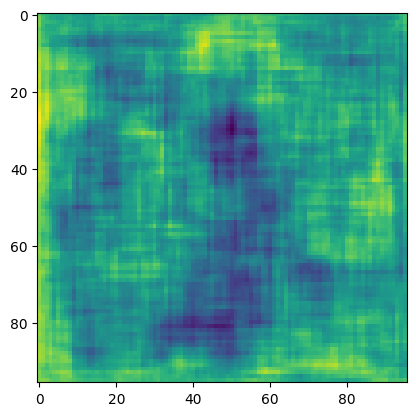

In [ ]:
def save_images(cnt,noise):
  image_array = np.full((
      PREVIEW_MARGIN + (PREVIEW_ROWS * (GENERATE_SQUARE+PREVIEW_MARGIN)),
      PREVIEW_MARGIN + (PREVIEW_COLS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 3),
      255, dtype=np.uint8)

  generated_images = generator.predict(noise)

  generated_images = 0.5 * generated_images + 0.5

  image_count = 0
  for row in range(PREVIEW_ROWS):
      for col in range(PREVIEW_COLS):
        r = row * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        c = col * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        image_array[r:r+GENERATE_SQUARE,c:c+GENERATE_SQUARE] = generated_images[image_count] * 255
        image_count += 1


  output_path = os.path.join(DATA_PATH,'output')
  if not os.path.exists(output_path):
    os.makedirs(output_path)

  filename = os.path.join(output_path,f"train-{cnt}.png")
  im = Image.fromarray(image_array)
  im.save(filename)
generator = build_generator(SEED_SIZE, IMAGE_CHANNELS)

noise = tf.random.normal([1, SEED_SIZE])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0])


In [ ]:
image_shape = (GENERATE_SQUARE,GENERATE_SQUARE,IMAGE_CHANNELS)

discriminator = build_discriminator(image_shape)
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.5000117]], shape=(1, 1), dtype=float32)


In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)

In [ ]:
@tf.function
def train_step(images):
  seed = tf.random.normal([BATCH_SIZE, SEED_SIZE])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(seed, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)


    gradients_of_generator = gen_tape.gradient(
        gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(
        disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(
        gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(
        gradients_of_discriminator,
        discriminator.trainable_variables))
  return gen_loss,disc_loss


#**Start the training.**

In [ ]:
def train(dataset, epochs):
  fixed_seed = np.random.normal(0, 1, (PREVIEW_ROWS * PREVIEW_COLS,
                                       SEED_SIZE))
  start = time.time()

  for epoch in range(epochs):
    epoch_start = time.time()

    gen_loss_list = []
    disc_loss_list = []

    for image_batch in dataset:
      t = train_step(image_batch)
      gen_loss_list.append(t[0])
      disc_loss_list.append(t[1])

    g_loss = sum(gen_loss_list) / len(gen_loss_list)
    d_loss = sum(disc_loss_list) / len(disc_loss_list)

    epoch_elapsed = time.time()-epoch_start
    print (f'Epoch {epoch+1}, gen loss={g_loss},disc loss={d_loss},'
           ' {hms_string(epoch_elapsed)}')
    save_images(epoch,fixed_seed)

  elapsed = time.time()-start
  print (f'Training time: {hms_string(elapsed)}')
train(train_dataset, EPOCHS)

Epoch 1, gen loss=1.7417004108428955,disc loss=1.0593998432159424, {hms_string(epoch_elapsed)}
1/1 [==============================] - 0s 125ms/step
Epoch 2, gen loss=2.7031607627868652,disc loss=0.9199535846710205, {hms_string(epoch_elapsed)}
1/1 [==============================] - 0s 19ms/step
Epoch 3, gen loss=2.467379331588745,disc loss=1.157253384590149, {hms_string(epoch_elapsed)}
1/1 [==============================] - 0s 18ms/step
Epoch 4, gen loss=2.460906744003296,disc loss=1.2002720832824707, {hms_string(epoch_elapsed)}
1/1 [==============================] - 0s 17ms/step
Epoch 5, gen loss=2.540574550628662,disc loss=1.3341071605682373, {hms_string(epoch_elapsed)}
1/1 [==============================] - 0s 17ms/step
Epoch 6, gen loss=2.0613861083984375,disc loss=1.249480128288269, {hms_string(epoch_elapsed)}
1/1 [==============================] - 0s 17ms/step
Epoch 7, gen loss=2.5567362308502197,disc loss=0.9623688459396362, {hms_string(epoch_elapsed)}
1/1 [======================